# Model Optimization with an Image Classification Example
1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
3. [Training the model](#Training-the-model)
4. [Inference with the vanilla model](#Inference-with-the-vanilla-model)
5. [Inference with optimized model](#Inference-with-the-optimized-model)

## Introduction

Welcome to our model optimization example for image classification.

In this demo, we will use the Amazon sagemaker image classification algorithm to train on the [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) and then we will demonstrate Amazon Sagemaker Neo's ability to optimize models.


To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'ic'

In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")

### Data preparation
Download the data and transfer to S3 for use in training. In this demo, we are using [Caltech-256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) dataset, which contains 30608 images of 256 objects. For the training and validation data, we follow the splitting scheme in this MXNet [example](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/data/caltech256.sh). In particular, it randomly selects 60 images per class for training, and uses the remaining data for validation. The algorithm takes `RecordIO` file as input. The user can also provide the image files as input, which will be converted into `RecordIO` format using MXNet's [im2rec](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) tool. It takes around 50 seconds to converted the entire Caltech-256 dataset (~1.2GB) on a p2.xlarge instance. However, for this demo, we will use record io format. 

In [3]:
import os 
import urllib.request
import boto3

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# caltech-256
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec')
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec')

In [4]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix)

# upload the lst files to train and validation channels
!aws s3 cp caltech-256-60-train.rec $s3train --quiet
!aws s3 cp caltech-256-60-val.rec $s3validation --quiet



Once we have the data available in the correct format for training, the next step is to actually train the model using the data. After setting training parameters, we kick off training, and poll for status until training is completed.


## Training the model

Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored


In [5]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.8xlarge', 
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess,
                                  base_job_name= 'greengrass-connector')

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [6]:
ic.set_hyperparameters(num_layers=18,
                             image_shape = "3,224,224",
                             num_classes=257,
                             num_training_samples=15420,
                             mini_batch_size=128,
                             epochs=5,
                             learning_rate=0.01,
                             top_k=2,
                             precision_dtype='float32',
                             use_pretrained_model=1)

## Input data specification
Set the data type and channels used for training

In [7]:
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

## Start the training
Start training by calling the fit method in the estimator

In [8]:
ic.fit(inputs=data_channels, logs=True)

2019-09-21 22:45:21 Starting - Starting the training job...
2019-09-21 22:45:23 Starting - Launching requested ML instances......
2019-09-21 22:46:23 Starting - Preparing the instances for training......
2019-09-21 22:47:48 Downloading - Downloading input data
2019-09-21 22:47:48 Training - Downloading the training image......
2019-09-21 22:48:39 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[09/21/2019 22:48:42 INFO 139827727935296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[09/21/2019 22:48:42 INFO 139827727935296] Read

[09/21/2019 22:49:29 INFO 139827727935296] Epoch[3] Validation-accuracy=0.757025
[09/21/2019 22:49:29 INFO 139827727935296] Storing the best model with validation accuracy: 0.757025
[09/21/2019 22:49:29 INFO 139827727935296] Saved checkpoint to "/opt/ml/model/image-classification-0004.params"
[09/21/2019 22:49:30 INFO 139827727935296] Epoch[4] Batch [20]#011Speed: 3222.571 samples/sec#011accuracy=0.969866#011top_k_accuracy_2=0.988467
[09/21/2019 22:49:31 INFO 139827727935296] Epoch[4] Batch [40]#011Speed: 3331.672 samples/sec#011accuracy=0.972752#011top_k_accuracy_2=0.989710
[09/21/2019 22:49:32 INFO 139827727935296] Epoch[4] Batch [60]#011Speed: 3371.229 samples/sec#011accuracy=0.977331#011top_k_accuracy_2=0.991291
[09/21/2019 22:49:32 INFO 139827727935296] Epoch[4] Batch [80]#011Speed: 3393.902 samples/sec#011accuracy=0.979649#011top_k_accuracy_2=0.991898
[09/21/2019 22:49:33 INFO 139827727935296] Epoch[4] Batch [100]#011Speed: 3406.310 samples/sec#011accuracy=0.981668#011top_k_accur

In [9]:
ic.latest_training_job.name

'greengrass-connector-2019-09-21-22-45-21-533'

# Inference with the vanilla model

***

Now we will test the trained model without any specific optimization for the hardware.

In [10]:
ic_classifier = ic.deploy(initial_instance_count = 1,
                          instance_type = 'ml.c5.4xlarge')

--------------------------------------------------------------------------------------------------!

### Download test image

--2019-09-21 22:58:20--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/080.frog/080_0001.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51453 (50K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  50.25K   331KB/s    in 0.2s    

2019-09-21 22:58:20 (331 KB/s) - ‘/tmp/test.jpg’ saved [51453/51453]



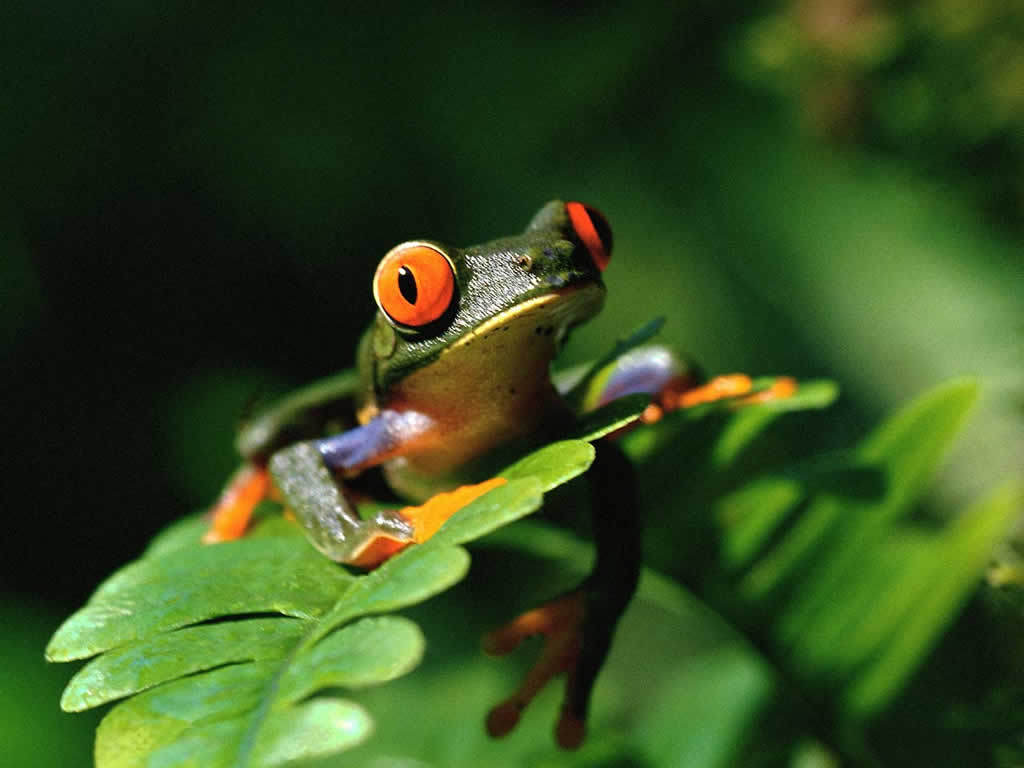

In [11]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/080.frog/080_0001.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, we have trained the model only for 5 epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [12]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
ic_classifier.content_type = 'application/x-image'

**Time the prediction with the vanilla model.**

In [13]:
%%time
result = json.loads(ic_classifier.predict(payload))

CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 465 ms


In [14]:
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - frog, probability - 0.9460169076919556


### Clean up


When we're done with the endpoint, we can just delete it and the backing instances will be released. Uncomment and run the following cell to delete the endpoint and model

In [15]:
ic_classifier.delete_endpoint()

# Inference with the optimized model

***

We will use Sagemaker Neo to optimize the model.

## Introduction to SageMaker Neo

***

[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) optimizes models to run up to fourth as fast, with less than a tenth of the memory footprint, with no loss in accuracy. You start with a machine learning model built using MXNet, TensorFlow, PyTorch, or XGBoost and trained using Amazon SageMaker. Then you choose your target hardware platform from Intel, NVIDIA, or ARM. With a single click, SageMaker Neo will then compile the trained model into an executable. In this example, we will use the model we just trained and see how well the optimized model could perform.

## Optimize the model specifically for the architecture using Neo API
Now we will compare the same model, but compiled specifically for the architecture we're deploying on.

In [16]:
output_path = '/'.join(ic.output_path.split('/')[:-1])
optimized_ic = ic.compile_model(target_instance_family='ml_c5', 
                                input_shape={'data':[1, 3, 224, 224]},  # Batch size 1, 3 channels, 224x224 Images.
                                output_path=output_path,
                                framework='mxnet', framework_version='1.2.1')

?.............!

In [17]:
optimized_ic.image = get_image_uri(sess.boto_region_name, 'image-classification-neo', repo_version="latest")
optimized_ic.name = 'deployed-image-classification'

## Deploy optimized model

In [18]:
optimized_ic_classifier = optimized_ic.deploy(initial_instance_count = 1,
                                              instance_type = 'ml.c5.4xlarge')

Using already existing model: deployed-image-classificationml-c5


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:658896902634:endpoint/deployed-image-classificationml-c5".

## Make predictions

In [ ]:
optimized_ic_classifier.content_type = 'application/x-image'

**Time the prediction with the optimized model.** We compare the optimized predictions times to the vanilla predictions times.

In [ ]:
%%time
result = json.loads(optimized_ic_classifier.predict(payload))

In [ ]:
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

## Conclusion
---
As you can notice the inference time using our neo-optimized model is better than the original one. SageMaker Neo automatically optimizes machine learning models to perform at up to fourth the speed with no loss in accuracy. In the diagram below shows you how our neo-optimized model performs 3x better with ResNet 152 in C5.9xlarge instance. The originl model stands for the uncompiled model deployed on Flask container on May 10th, 2019 and neo-optimized model stands for the compiled model deployed on Neo-AI-DLR container. The data for each trial is the average of 1000 trys for each endpoint.
![alt text](image-classification-latency.png "Title")


## Clean up


When we're done with the endpoint, we can just delete it and the backing instances will be released. Uncomment and run the following cell to delete the endpoint and model

In [ ]:
optimized_ic_classifier.delete_endpoint()